# Adding different classification models except in the research paper to the experimentation process.

✅ Models
- Logistic Regression
- Neural Network

✅ Code Workflow
1. Model training and evaluation using train_classes.csv - Validation Set
   - Split the training data further into train and validation data
   - Perform hyperparameter tuning with GridSearchCV or similar methods
   - Assess performance on the validation set

2. Final evaluation using test_classes.csv - Test Set
   - Use the optimal model trained on train + validation data
   - Generate predictions on the test set

3. Re-training and evaluation using the combined train_classes.csv and test_classes.csv - Combined Set (Validation Set + Test Set)
   - Rebuild the model using the entire dataset
   - Obtain the final model trained on all available data


## Preprocessing Data

In [3]:
import numpy as np
from PIL import Image
import os

def rgb_to_cmy(rgb_image):
    # CMY = 1 - RGB
    cmy_image = 1.0 - rgb_image
    return cmy_image

def extract_color_features(image):
    features = []
    # RGB features (6)
    for channel in range(3):
        channel_data = image[:, :, channel]
        features.append(np.mean(channel_data))
        features.append(np.std(channel_data))
    
    # CMY features (6)
    cmy_image = rgb_to_cmy(image)
    for channel in range(3):
        channel_data = cmy_image[:, :, channel]
        features.append(np.mean(channel_data))
        features.append(np.std(channel_data))
    
    return np.array(features)

def load_and_extract_features(image_dir, labels_df):
    features_list = []
    valid_indices = []
    
    for idx, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['id']}.jpg")
        
        if os.path.exists(img_path):
            img = Image.open(img_path)
            img_resized = img.resize((410, 205))
            img_array = np.array(img_resized).astype('float32') / 255.0
            
            features = extract_color_features(img_array)
            features_list.append(features)
            valid_indices.append(idx)
        else:
            print(f"Warning: {img_path} not found")
    
    features_array = np.array(features_list)
    labels = labels_df.loc[valid_indices].reset_index(drop=True)
    
    return features_array, labels

def convert_to_single_label(row):
    if row['miner'] == 1:
        return 'miner'
    elif row['phoma'] == 1:
        return 'phoma'
    elif row['rust'] == 1:
        return 'rust'
    else:
        return 'nodisease'

## 1.Validation Set

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder 
import pandas as pd

train_label_df = pd.read_csv('dataset/train_classes.csv')

train_label_df['label'] = train_label_df.apply(convert_to_single_label, axis=1)

train_features, train_labels = load_and_extract_features('dataset/coffee-leaf-diseases/train/images', train_label_df)

X_train, X_valid, y_train, y_valid = train_test_split(
    train_features,
    train_labels['label'],
    test_size=0.2,
    stratify=train_labels['label'],
    random_state=123
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

### Hyperparameter Tuning and GridSearch

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(max_features=None, random_state=123, splitter='best')
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 21)) + [None],
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 6)
}

grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=10)
grid_search_dt.fit(X_train_scaled, y_train)

best_model_dt = grid_search_dt.best_estimator_
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)

# ---------- KNN ----------
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, n_jobs=-1, p=2, weights='uniform')
param_grid_knn = {
    'metric': ['euclidean', 'manhattan'],
    'n_neighbors': range(1, 21),
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=10)
grid_search_knn.fit(X_train_scaled, y_train)

best_model_knn = grid_search_knn.best_estimator_
print(grid_search_knn.best_params_)
print(grid_search_knn.best_score_)

# ---------- Logistic Regression ----------
lr = LogisticRegression(max_iter=1000, random_state=123)
param_grid_lr = {
    'solver': ['lbfgs', 'saga'],
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

best_model_lr = grid_search_lr.best_estimator_
print(grid_search_lr.best_params_)
print(grid_search_lr.best_score_)

# ---------- Neural network ----------
nn = MLPClassifier(max_iter=5000, random_state=123)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}
grid_search_nn = GridSearchCV(estimator=nn, param_grid=param_grid,cv=10, scoring='accuracy', n_jobs=-1)
grid_search_nn.fit(X_train_scaled, y_train)

best_model_nn = grid_search_nn.best_estimator_
print(grid_search_nn.best_params_)
print(grid_search_nn.best_score_)

{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.994059405940594
{'metric': 'euclidean', 'n_neighbors': 1}
0.993069306930693
{'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.7220442632498544
{'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
0.9970297029702969


In [6]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

results = []
for name, gs in [("Decision Tree", grid_search_dt),
                 ("KNN", grid_search_knn),
                 ("Logistic Regression", grid_search_lr),
                 ("Neural Network", grid_search_nn)]:
    results.append({
        "Model": name,
        "Best Params": gs.best_params_,
        "CV Score": gs.best_score_
    })
pd.DataFrame(results)

,Model,Best Params,CV Score
0,Decision Tree,"{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.994059
1,KNN,"{'metric': 'euclidean', 'n_neighbors': 1}",0.993069
2,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.722044
3,Neural Network,"{'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}",0.997030


### Evaluation using the best parameters

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ---------- Decision Tree ----------
y_pred_valid_dt_best = best_model_dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_dt_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_valid_knn_best = best_model_knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_knn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))

# ---------- Logistic Regression ----------
y_pred_valid_lr_best = best_model_lr.predict(X_valid_scaled)

print("\n=== Logistic Regression Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_lr_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))

# ---------- Neural Network ----------
y_pred_valid_nn_best = best_model_nn.predict(X_valid_scaled)

print("\n=== Neural Network Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_nn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== Logistic Regression Overall Metrics ===
Accuracy (subset accuracy): 0.7114624505928854
Precision (micro): 0.7114624505928854
Recall (micro): 0.7114624505928854
F1-score (micro): 0.7114624505928854
Precision (macro): 0.6890723503244232
Recall (macro): 0.6926297386823703
F1-score (macro): 0.6890021862403498

=== Neural Network Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0


In [8]:
results_valid = []
for name, model, y_pred in [
    ("Decision Tree", best_model_dt, y_pred_valid_dt_best),
    ("KNN", best_model_knn, y_pred_valid_knn_best),
    ("Logistic Regression", best_model_lr, y_pred_valid_lr_best),
    ("Neural Network", best_model_nn, y_pred_valid_nn_best)
]:
    results_valid.append({
        "Model": name,
        "Accuracy": accuracy_score(y_valid, y_pred),
        "Precision (micro)": precision_score(y_valid, y_pred, average='micro', zero_division=0),
        "Recall (micro)": recall_score(y_valid, y_pred, average='micro', zero_division=0),
        "F1-score (micro)": f1_score(y_valid, y_pred, average='micro', zero_division=0),
        "Precision (macro)": precision_score(y_valid, y_pred, average='macro', zero_division=0),
        "Recall (macro)": recall_score(y_valid, y_pred, average='macro', zero_division=0),
        "F1_macro (macro)": f1_score(y_valid, y_pred, average='macro', zero_division=0),
    })
pd.DataFrame(results_valid)

,Model,Accuracy,Precision (micro),Recall (micro),F1-score (micro),Precision (macro),Recall (macro),F1_macro (macro)
0,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
1,KNN,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
2,Logistic Regression,0.711462,0.711462,0.711462,0.711462,0.689072,0.69263,0.689002
3,Neural Network,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


### Confusion Matrix Heatmap

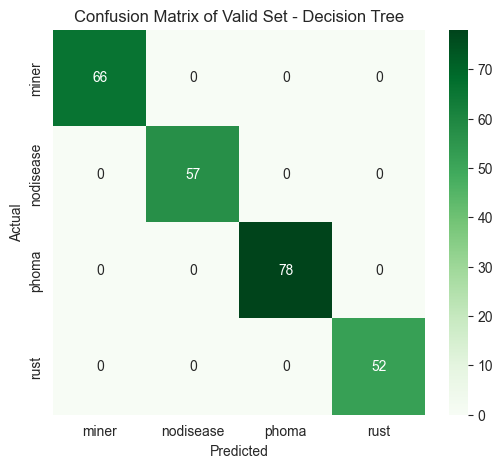

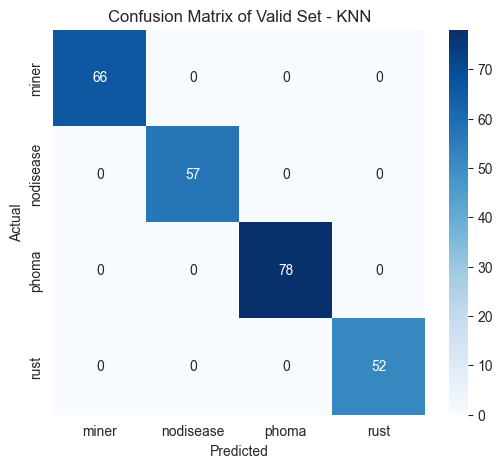

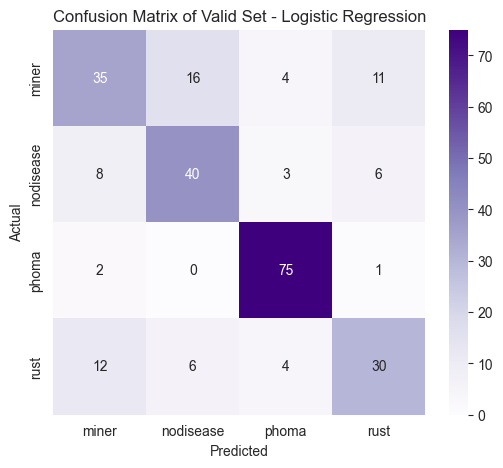

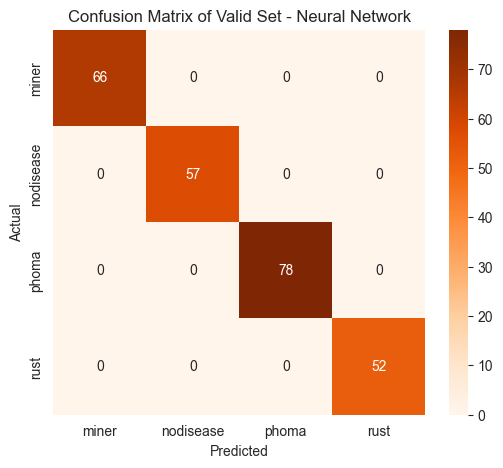

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(y_valid.unique())

# ---------- Decision Tree ----------
cm_valid_dt_best = confusion_matrix(y_valid, y_pred_valid_dt_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_dt_best,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Valid Set - Decision Tree')
plt.show()

# ---------- KNN ----------
cm_valid_knn_best = confusion_matrix(y_valid, y_pred_valid_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_knn_best,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Valid Set - KNN')
plt.show()

# ---------- Logistic Regression ----------
cm_valid_lr_best = confusion_matrix(y_valid, y_pred_valid_lr_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_lr_best,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Valid Set - Logistic Regression')
plt.show()

# ---------- Neural network ----------
cm_valid_nn_best = confusion_matrix(y_valid, y_pred_valid_nn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_nn_best,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Valid Set - Neural Network')
plt.show()

### ROC-AUC Curves

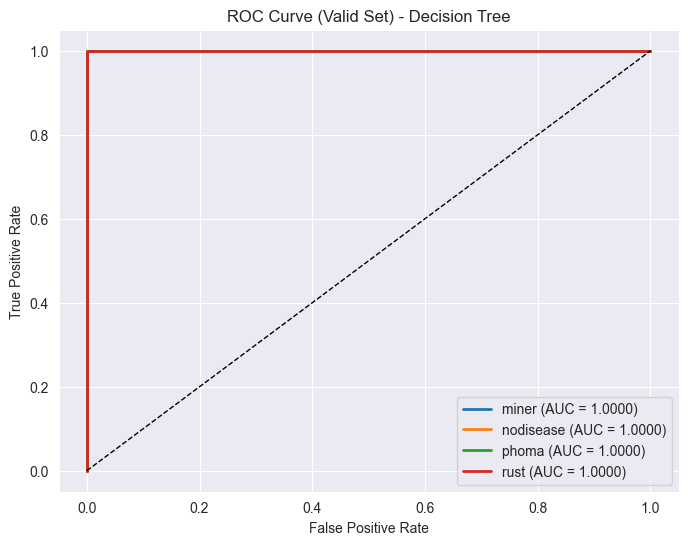

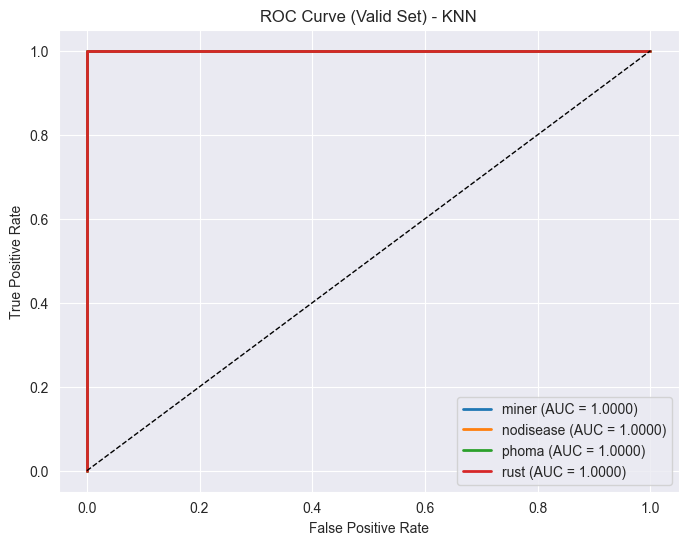

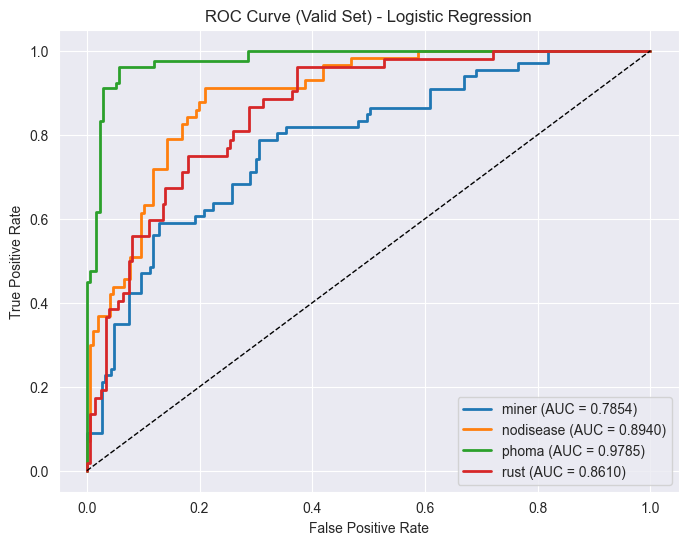

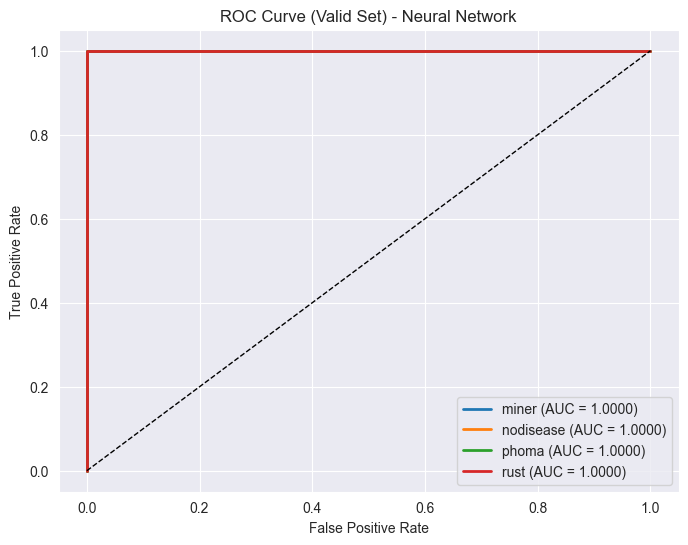

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Decision Tree
y_score_valid_dt_best = best_model_dt.predict_proba(X_valid_scaled)
y_bin_valid_dt_best = label_binarize(y_valid, classes=best_model_dt.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_dt.classes_):
    fpr_dt, tpr_dt, _ = roc_curve(y_bin_valid_dt_best[:, i], y_score_valid_dt_best[:, i])
    roc_auc_dt_best = auc(fpr_dt, tpr_dt)
    plt.plot(
        fpr_dt,
        tpr_dt,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_dt_best:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Valid Set) - Decision Tree')
plt.legend()
plt.show()

# ---------- KNN ----------
y_score_valid_knn_best = best_model_knn.predict_proba(X_valid_scaled)
y_bin_valid_knn_best = label_binarize(y_valid, classes=best_model_knn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_knn.classes_):
    fpr_knn, tpr_knn, _ = roc_curve(y_bin_valid_knn_best[:, i], y_score_valid_knn_best[:, i])
    roc_auc_knn_best = auc(fpr_knn, tpr_knn)
    plt.plot(
        fpr_knn,
        tpr_knn,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_knn_best:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Valid Set) - KNN')
plt.legend()
plt.show()

# ---------- Logistic Regression ----------
y_score_valid_lr_best = best_model_lr.predict_proba(X_valid_scaled)
y_bin_valid_lr_best = label_binarize(y_valid, classes=best_model_lr.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_lr.classes_):
    fpr_lr, tpr_lr, _ = roc_curve(y_bin_valid_lr_best[:, i], y_score_valid_lr_best[:, i])
    roc_auc_lr_best = auc(fpr_lr, tpr_lr)
    plt.plot(
        fpr_lr,
        tpr_lr,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_lr_best:.4f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Valid Set) - Logistic Regression')
plt.legend()
plt.show()

# ---------- Neural network ----------
y_score_valid_nn_best = best_model_nn.predict_proba(X_valid_scaled)
y_bin_valid_nn_best = label_binarize(y_valid, classes=best_model_nn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_nn.classes_):
    fpr_nn, tpr_nn, _ = roc_curve(y_bin_valid_nn_best[:, i], y_score_valid_nn_best[:, i])
    roc_auc_nn_best = auc(fpr_nn, tpr_nn)
    plt.plot(
        fpr_nn,
        tpr_nn,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_nn_best:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Valid Set) - Neural Network')
plt.legend()
plt.show()

## 2. Test Set

In [11]:
test_label_df = pd.read_csv('dataset/test_classes.csv')
test_label_df['label'] = test_label_df.apply(convert_to_single_label, axis=1)

test_features, test_labels = load_and_extract_features('dataset/coffee-leaf-diseases/test/images', test_label_df)

y_test = test_labels['label']

y_test_encoded = label_encoder.transform(y_test)
X_test_scaled = scaler.transform(test_features)

#### Evaluation using the best parameters

In [12]:
# ---------- Decision Tree ----------
y_pred_test_dt_best = best_model_dt.predict(X_test_scaled)

print("\n=== Decision Tree Test Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_test_dt_best))
print("Precision (micro):", precision_score(y_test, y_pred_test_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_test_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_test_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_test_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_test_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_test_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_test_knn_best = best_model_knn.predict(X_test_scaled)

print("\n=== KNN Test Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_test_knn_best))
print("Precision (micro):", precision_score(y_test, y_pred_test_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_test_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_test_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_test_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_test_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_test_knn_best, average='macro', zero_division=0))

# ---------- Logistic Regression ----------
y_pred_test_lr_best = best_model_lr.predict(X_test_scaled)

print("\n=== Logistic Regression Test Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_test_lr_best))
print("Precision (micro):", precision_score(y_test, y_pred_test_lr_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_test_lr_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_test_lr_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_test_lr_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_test_lr_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_test_lr_best, average='macro', zero_division=0))

# ---------- Neural Network ----------
y_pred_test_nn_best = best_model_nn.predict(X_test_scaled)

print("\n=== Neural Network Test Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_test_nn_best))
print("Precision (micro):", precision_score(y_test, y_pred_test_nn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_test_nn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_test_nn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_test_nn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_test_nn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_test_nn_best, average='macro', zero_division=0))


=== Decision Tree Test Metrics ===
Accuracy (subset accuracy): 0.6
Precision (micro): 0.6
Recall (micro): 0.6
F1-score (micro): 0.6
Precision (macro): 0.5777687626774848
Recall (macro): 0.6011314655172414
F1-score (macro): 0.586070764740924

=== KNN Test Metrics ===
Accuracy (subset accuracy): 0.65
Precision (micro): 0.65
Recall (micro): 0.65
F1-score (micro): 0.65
Precision (macro): 0.6245017281105991
Recall (macro): 0.6426185344827586
F1-score (macro): 0.6284756163788422

=== Logistic Regression Test Metrics ===
Accuracy (subset accuracy): 0.82
Precision (micro): 0.82
Recall (micro): 0.82
F1-score (micro): 0.82
Precision (macro): 0.8196225071225072
Recall (macro): 0.840642959770115
F1-score (macro): 0.8178506191488522

=== Neural Network Test Metrics ===
Accuracy (subset accuracy): 0.67
Precision (micro): 0.67
Recall (micro): 0.67
F1-score (micro): 0.67
Precision (macro): 0.666917389258587
Recall (macro): 0.6874102011494253
F1-score (macro): 0.6739556138060133


In [13]:
results_test = []
for name, model, y_pred in [
    ("Decision Tree", best_model_dt, y_pred_test_dt_best),
    ("KNN", best_model_knn, y_pred_test_knn_best),
    ("Logistic Regression", best_model_lr, y_pred_test_lr_best),
    ("Neural Network", best_model_nn, y_pred_test_nn_best)
]:
    results_test.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (micro)": precision_score(y_test, y_pred, average='micro', zero_division=0),
        "Recall (micro)": recall_score(y_test, y_pred, average='micro', zero_division=0),
        "F1-score (micro)": f1_score(y_test, y_pred, average='micro', zero_division=0),
        "Precision (macro)": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Recall (macro)": recall_score(y_test, y_pred, average='macro', zero_division=0),
        "F1-score (macro)": f1_score(y_test, y_pred, average='macro', zero_division=0),
    })

pd.DataFrame(results_test)

,Model,Accuracy,Precision (micro),Recall (micro),F1-score (micro),Precision (macro),Recall (macro),F1-score (macro)
0,Decision Tree,0.60,0.60,0.60,0.60,0.577769,0.601131,0.586071
1,KNN,0.65,0.65,0.65,0.65,0.624502,0.642619,0.628476
2,Logistic Regression,0.82,0.82,0.82,0.82,0.819623,0.840643,0.817851
3,Neural Network,0.67,0.67,0.67,0.67,0.666917,0.687410,0.673956


### Confusion Matrix Heatmap

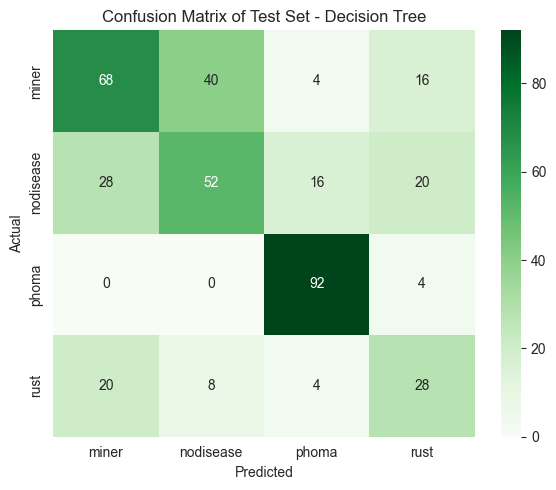

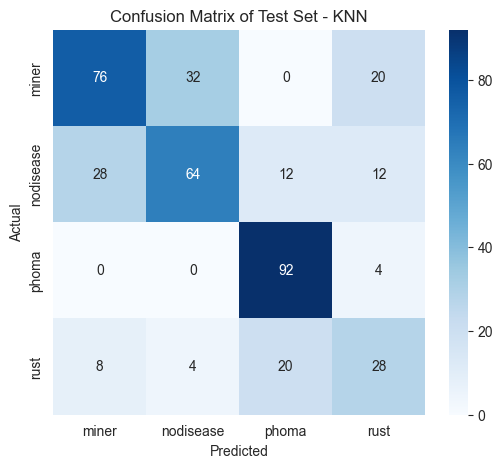

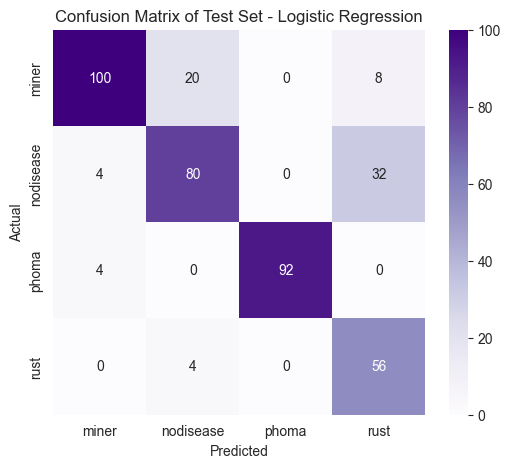

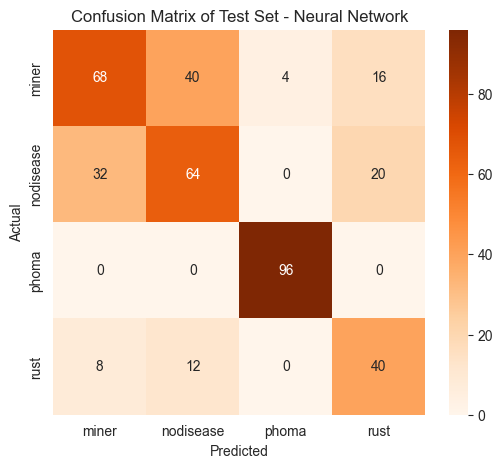

In [14]:
labels = sorted(list(set(y_test)))

# ---------- Decision Tree ----------
cm_test_dt = confusion_matrix(y_test, y_pred_test_dt_best)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_dt,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Test Set - Decision Tree')
plt.tight_layout()
plt.show()

# ---------- KNN ----------
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_knn,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Test Set - KNN')
plt.show()

# ---------- Logistic Regression ----------
cm_test_lr = confusion_matrix(y_test, y_pred_test_lr_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_lr,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Test Set - Logistic Regression')
plt.show()

# ---------- Neural network ----------
cm_test_nn = confusion_matrix(y_test, y_pred_test_nn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_nn,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Test Set - Neural Network')
plt.show()

### ROC-AUC Curves

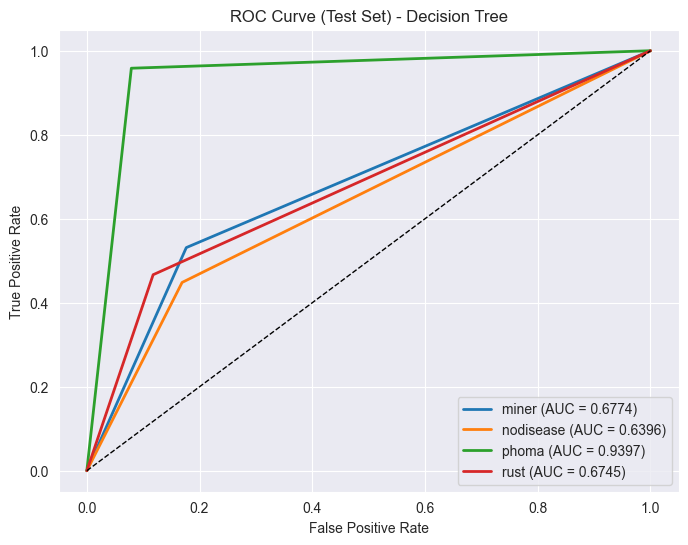

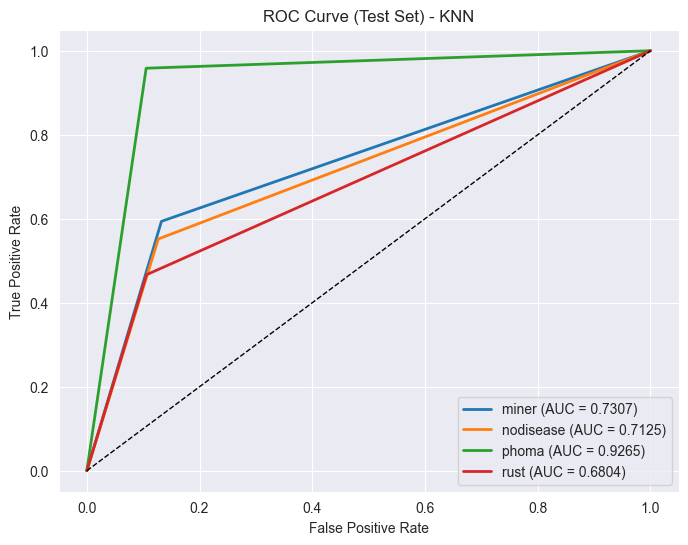

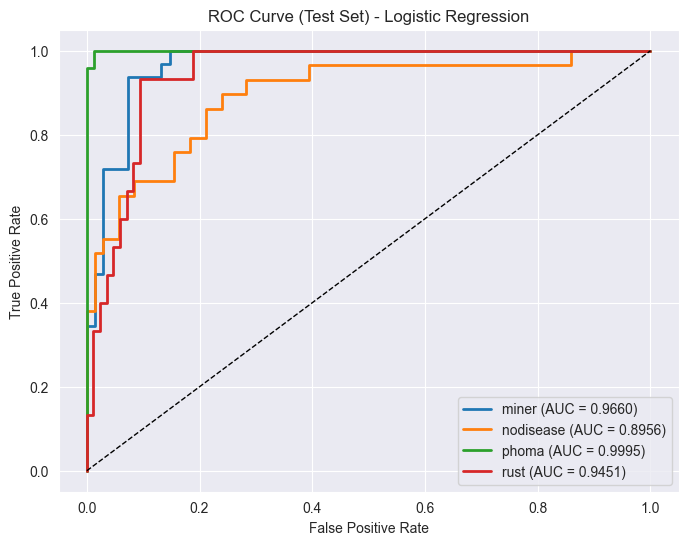

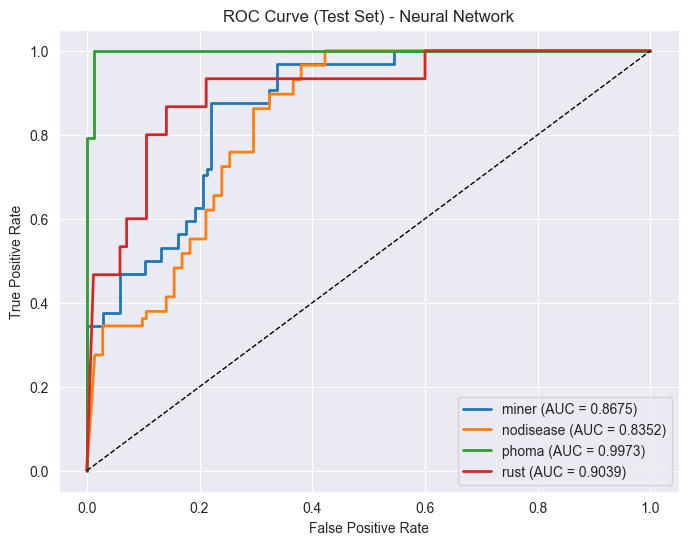

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ---------- Decision Tree ----------
y_score_test_dt_best = best_model_dt.predict_proba(X_test_scaled)
y_bin_test_dt_best = label_binarize(y_test, classes=best_model_dt.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_dt.classes_):
    fpr_dt, tpr_dt, _ = roc_curve(y_bin_test_dt_best[:, i], y_score_test_dt_best[:, i])
    roc_auc_dt_best = auc(fpr_dt, tpr_dt)
    plt.plot(fpr_dt, tpr_dt, lw=2, label=f'{class_name} (AUC = {roc_auc_dt_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set) - Decision Tree')
plt.legend()
plt.show()

# ---------- KNN ----------
y_score_test_knn_best = best_model_knn.predict_proba(X_test_scaled)
y_bin_test_knn_best = label_binarize(y_test, classes=best_model_knn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_knn.classes_):
    fpr_knn, tpr_knn, _ = roc_curve(y_bin_test_knn_best[:, i], y_score_test_knn_best[:, i])
    roc_auc_knn_best = auc(fpr_knn, tpr_knn)
    plt.plot(fpr_knn, tpr_knn, lw=2, label=f'{class_name} (AUC = {roc_auc_knn_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set) - KNN')
plt.legend()
plt.show()

# ---------- Logistic Regression ----------
y_score_test_lr_best = best_model_lr.predict_proba(X_test_scaled)
y_bin_test_lr_best = label_binarize(y_test, classes=best_model_lr.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_lr.classes_):
    fpr_lr, tpr_lr, _ = roc_curve(y_bin_test_lr_best[:, i], y_score_test_lr_best[:, i])
    roc_auc_lr_best = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, lw=2, label=f'{class_name} (AUC = {roc_auc_lr_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set) - Logistic Regression')
plt.legend()
plt.show()

# ---------- Neural Network ----------
y_score_test_nn_best = best_model_nn.predict_proba(X_test_scaled)
y_bin_test_nn_best = label_binarize(y_test, classes=best_model_nn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_nn.classes_):
    fpr_nn, tpr_nn, _ = roc_curve(y_bin_test_nn_best[:, i], y_score_test_nn_best[:, i])
    roc_auc_nn_best = auc(fpr_nn, tpr_nn)
    plt.plot(fpr_nn, tpr_nn, lw=2, label=f'{class_name} (AUC = {roc_auc_nn_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set) - Neural Network')
plt.legend()
plt.show()

## 3. Combined Set (Validation Set + Test Set)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

train_label_df = pd.read_csv('dataset/train_classes.csv')
test_label_df  = pd.read_csv('dataset/test_classes.csv')

train_label_df['label'] = train_label_df.apply(convert_to_single_label, axis=1)
test_label_df['label']  = test_label_df.apply(convert_to_single_label, axis=1)

train_features, train_labels = load_and_extract_features('dataset/coffee-leaf-diseases/train/images', train_label_df)
test_features, test_labels = load_and_extract_features('dataset/coffee-leaf-diseases/test/images', test_label_df)

all_features = np.vstack([train_features, test_features])
all_labels   = pd.concat([train_labels['label'], test_labels['label']], axis=0, ignore_index=True)

X_train, X_valid, y_train, y_valid = train_test_split(
    all_features,
    all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=123
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

### Hyperparameter Tuning and Grid Search

In [17]:
# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(max_features=None, random_state=123, splitter='best')
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 21)) + [None],
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 6)
}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=10)
grid_search_dt.fit(X_train_scaled, y_train)

best_model_dt = grid_search_dt.best_estimator_
print("Decision Tree best params:", grid_search_dt.best_params_)
print("Decision Tree CV score:", grid_search_dt.best_score_)

# ---------- KNN ----------
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, n_jobs=-1, p=2, weights='uniform')
param_grid_knn = {
    'metric': ['euclidean', 'manhattan'],
    'n_neighbors': range(1, 21),
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=10)
grid_search_knn.fit(X_train_scaled, y_train)

best_model_knn = grid_search_knn.best_estimator_
print("KNN best params:", grid_search_knn.best_params_)
print("KNN CV score:", grid_search_knn.best_score_)

# ---------- Logistic Regression ----------
lr = LogisticRegression(max_iter=1000, random_state=123)
param_grid_lr = {
    'solver': ['lbfgs', 'saga'],
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

best_model_lr = grid_search_lr.best_estimator_
print("Logistic Regression best params:", grid_search_lr.best_params_)
print("Logistic Regression CV score:", grid_search_lr.best_score_)

# ---------- Neural Network ----------
nn = MLPClassifier(max_iter=5000, random_state=123)
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

grid_search_nn = GridSearchCV(nn, param_grid_nn, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_nn.fit(X_train_scaled, y_train)

best_model_nn = grid_search_nn.best_estimator_
print("Neural Network best params:", grid_search_nn.best_params_)
print("Neural Network CV score:", grid_search_nn.best_score_)

Decision Tree best params: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree CV score: 0.9864829985411289
KNN best params: {'metric': 'manhattan', 'n_neighbors': 1}
KNN CV score: 0.9872461003254405
Logistic Regression best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression CV score: 0.728750981932443
Neural Network best params: {'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
Neural Network CV score: 0.9954999438895747


In [18]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

results_combine = []
for name, gs in [("Decision Tree", grid_search_dt),
                 ("KNN", grid_search_knn),
                 ("Logistic Regression", grid_search_lr),
                 ("Neural Network", grid_search_nn)]:
    results_combine.append({
        "Model": name,
        "Best Params": gs.best_params_,
        "CV Score": gs.best_score_
    })

pd.DataFrame(results_combine)

,Model,Best Params,CV Score
0,Decision Tree,"{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.986483
1,KNN,"{'metric': 'manhattan', 'n_neighbors': 1}",0.987246
2,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.728751
3,Neural Network,"{'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}",0.995500


### Evaluation using the best parameters

In [19]:
# ---------- Decision Tree ----------
y_pred_valid_dt_best = best_model_dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics (Combine) ===")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid_dt_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_valid_knn_best = best_model_knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics (Combine) ===")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid_knn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))

# ---------- Logistic Regression ----------
y_pred_valid_lr_best = best_model_lr.predict(X_valid_scaled)

print("\n=== Logistic Regression Overall Metrics (Combine) ===")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid_lr_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))

# ---------- Neural Network ----------
y_pred_valid_nn_best = best_model_nn.predict(X_valid_scaled)

print("\n=== Neural Network Overall Metrics (Combine) ===")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid_nn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))


=== Decision Tree Overall Metrics (Combine) ===
Accuracy: 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== KNN Overall Metrics (Combine) ===
Accuracy: 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== Logistic Regression Overall Metrics (Combine) ===
Accuracy: 0.7177177177177178
Precision (micro): 0.7177177177177178
Recall (micro): 0.7177177177177178
F1-score (micro): 0.7177177177177178
Precision (macro): 0.7032054088233863
Recall (macro): 0.6980340934558494
F1-score (macro): 0.6978101386161256

=== Neural Network Overall Metrics (Combine) ===
Accuracy: 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0


In [20]:
results_valid_combine = []
for name, y_pred in [
    ("Decision Tree", y_pred_valid_dt_best),
    ("KNN", y_pred_valid_knn_best),
    ("Logistic Regression", y_pred_valid_lr_best),
    ("Neural Network", y_pred_valid_nn_best)
]:
    results_valid_combine.append({
        "Model": name,
        "Accuracy": accuracy_score(y_valid, y_pred),
        "Precision (micro)": precision_score(y_valid, y_pred, average='micro', zero_division=0),
        "Recall (micro)": recall_score(y_valid, y_pred, average='micro', zero_division=0),
        "F1-score (micro)": f1_score(y_valid, y_pred, average='micro', zero_division=0),
        "Precision (macro)": precision_score(y_valid, y_pred, average='macro', zero_division=0),
        "Recall (macro)": recall_score(y_valid, y_pred, average='macro', zero_division=0),
        "F1-score (macro)": f1_score(y_valid, y_pred, average='macro', zero_division=0),
    })
pd.DataFrame(results_valid_combine)

,Model,Accuracy,Precision (micro),Recall (micro),F1-score (micro),Precision (macro),Recall (macro),F1-score (macro)
0,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
1,KNN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
2,Logistic Regression,0.717718,0.717718,0.717718,0.717718,0.703205,0.698034,0.69781
3,Neural Network,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### Confusion Matrix Heatmap

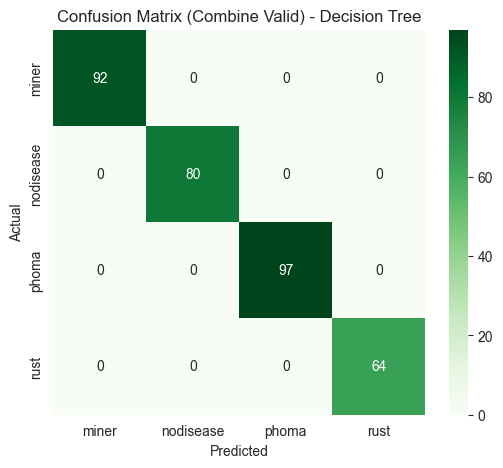

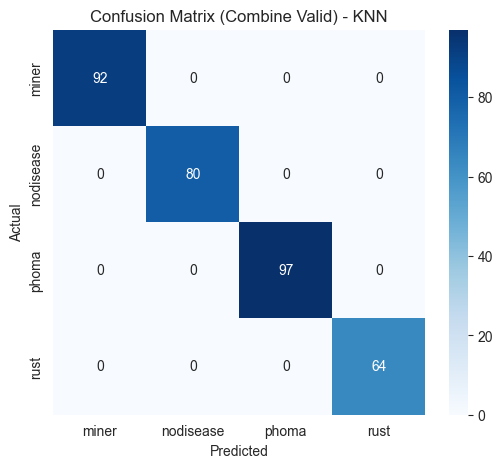

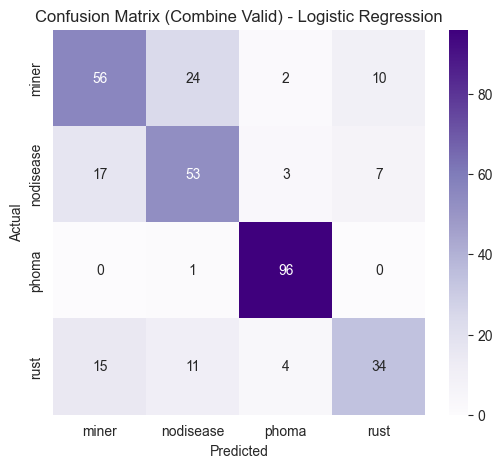

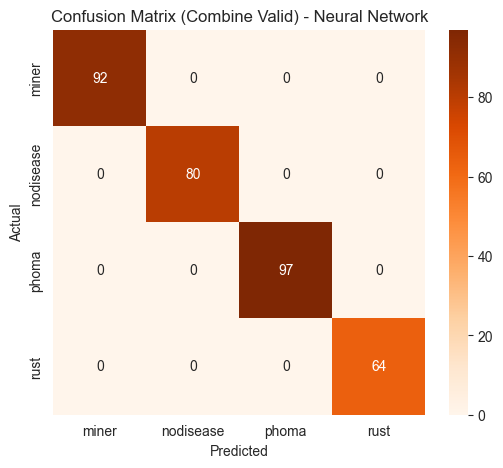

In [21]:
labels = sorted(y_valid.unique())

# ---------- Decision Tree ----------
cm_valid_dt_best = confusion_matrix(y_valid, y_pred_valid_dt_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid_dt_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Combine Valid) - Decision Tree')
plt.show()

# ---------- KNN ----------
cm_valid_knn_best = confusion_matrix(y_valid, y_pred_valid_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid_knn_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Combine Valid) - KNN')
plt.show()

# ---------- Logistic Regression ----------
cm_valid_lr_best = confusion_matrix(y_valid, y_pred_valid_lr_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid_lr_best, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Combine Valid) - Logistic Regression')
plt.show()

# ---------- Neural Network ----------
cm_valid_nn_best = confusion_matrix(y_valid, y_pred_valid_nn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid_nn_best, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Combine Valid) - Neural Network')
plt.show()

### ROC-AUC Curves

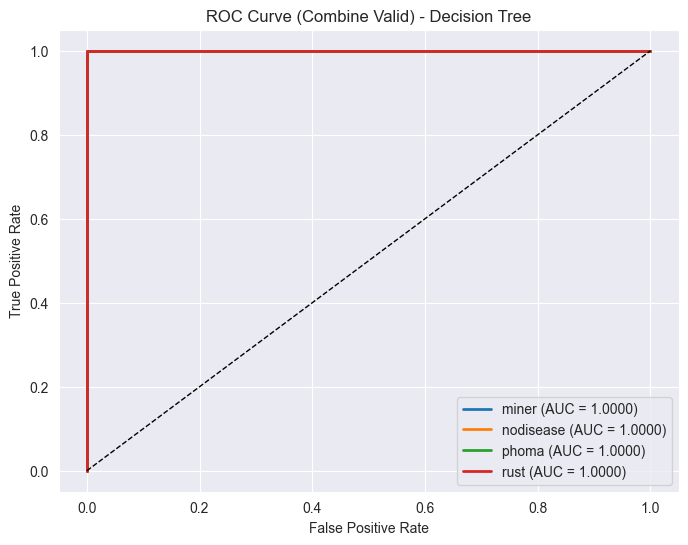

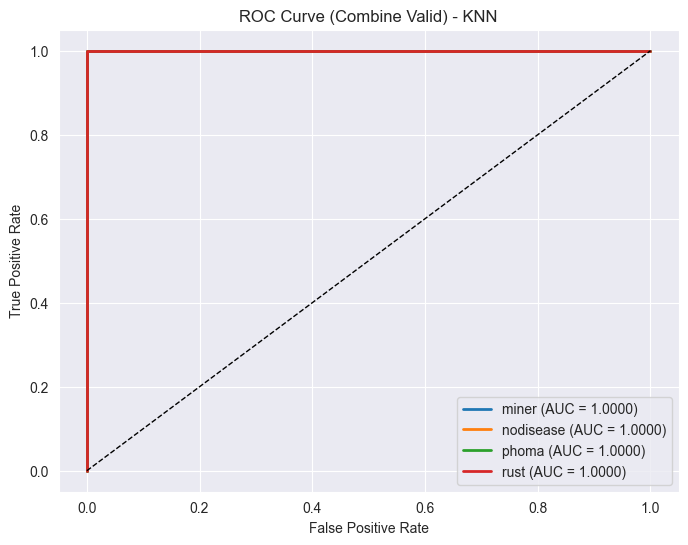

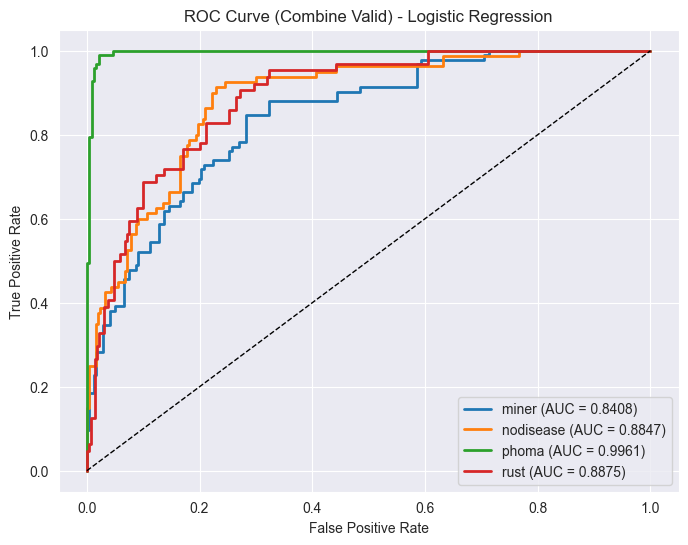

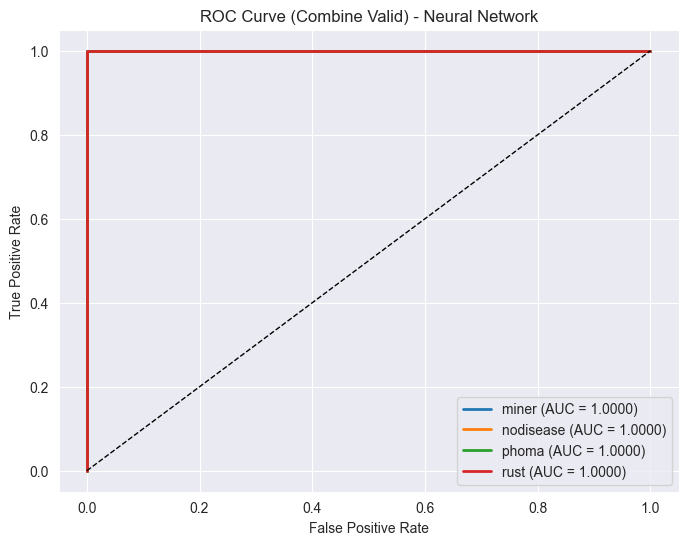

In [22]:
labels = sorted(y_valid.unique())

# ---------- Decision Tree ----------
y_score_valid_dt_best = best_model_dt.predict_proba(X_valid_scaled)
y_bin_valid_dt_best = label_binarize(y_valid, classes=best_model_dt.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_dt.classes_):
    fpr_dt, tpr_dt, _ = roc_curve(y_bin_valid_dt_best[:, i], y_score_valid_dt_best[:, i])
    roc_auc_dt_best = auc(fpr_dt, tpr_dt)
    plt.plot(fpr_dt, tpr_dt, lw=2, label=f'{class_name} (AUC = {roc_auc_dt_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Combine Valid) - Decision Tree')
plt.legend()
plt.show()

# ---------- KNN ----------
y_score_valid_knn_best = best_model_knn.predict_proba(X_valid_scaled)
y_bin_valid_knn_best = label_binarize(y_valid, classes=best_model_knn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_knn.classes_):
    fpr_knn, tpr_knn, _ = roc_curve(y_bin_valid_knn_best[:, i], y_score_valid_knn_best[:, i])
    roc_auc_knn_best = auc(fpr_knn, tpr_knn)
    plt.plot(fpr_knn, tpr_knn, lw=2, label=f'{class_name} (AUC = {roc_auc_knn_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Combine Valid) - KNN')
plt.legend()
plt.show()

# ---------- Logistic Regression ----------
y_score_valid_lr_best = best_model_lr.predict_proba(X_valid_scaled)
y_bin_valid_lr_best = label_binarize(y_valid, classes=best_model_lr.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_lr.classes_):
    fpr_lr, tpr_lr, _ = roc_curve(y_bin_valid_lr_best[:, i], y_score_valid_lr_best[:, i])
    roc_auc_lr_best = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, lw=2, label=f'{class_name} (AUC = {roc_auc_lr_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Combine Valid) - Logistic Regression')
plt.legend()
plt.show()

# ---------- Neural Network ----------
y_score_valid_nn_best = best_model_nn.predict_proba(X_valid_scaled)
y_bin_valid_nn_best = label_binarize(y_valid, classes=best_model_nn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_nn.classes_):
    fpr_nn, tpr_nn, _ = roc_curve(y_bin_valid_nn_best[:, i], y_score_valid_nn_best[:, i])
    roc_auc_nn_best = auc(fpr_nn, tpr_nn)
    plt.plot(fpr_nn, tpr_nn, lw=2, label=f'{class_name} (AUC = {roc_auc_nn_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Combine Valid) - Neural Network')
plt.legend()
plt.show()